In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED_Dataset
from ModelClass import UNET
from torch.utils.tensorboard import SummaryWriter
import sys
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# set device and clean up
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()
print(f"running on '{device}'")


# dataset
data_root = '/storage/remote/atcremers40/motion_seg/datasets/KITTI_MOD_fixed/training/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
dataset = KITTI_MOD_FIXED_Dataset(data_root, data_transforms)


# specify some hyperparams
lr = 5e-3
batch_size = 2
epochs = 100

# data split and data loader
train_size = int(0.5 *  len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

# init model and pass to `device`
input_channels=6
output_channels=1
model = UNET(in_channels=input_channels, out_channels=output_channels).to(device)
model = model.float()

# for running single batch
# [data, targets] = next(iter(train_loader))

# loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

running on 'cuda:0'


In [2]:
def run_val(loader, model):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            x = x.to(device=device).float()
            y = y.to(device=device).float()

            # forward
            scores = model(x)
            # scores = torch.round(scores)
            # loss = sigmoid_focal_loss(scores, y, reduction="sum")
            loss = criterion(scores, y)
            val_losses.append(loss.item())

            if (batch_idx + 1) % 20 == 0:
                writer.add_scalar("val loss", sum(val_losses)/len(val_losses), epoch*len(val_loader)+batch_idx) 

    # set back to train ensures layers like dropout, batchnorm are used after eval
    model.train()
    return sum(val_losses)/len(val_losses)

In [7]:
# initialise tensorboard
now = datetime.now()
now_string = now.strftime("%d.%m.%Y_%H:%M:%S")
writer = SummaryWriter("runs/" + now_string)

# train network
print("train network ...")
train_loss = []
val_loss = []
for epoch in range(epochs):
    model.train()
    losses = []
    steps_per_epoch = len(train_loader)

    for batch_idx, (data, targets) in enumerate(train_loader):

        # move data to gpu if available
        data = data.to(device).float()
        targets = targets.to(device).float()

        # forward
        scores = model(data)
        # loss = sigmoid_focal_loss(scores, targets, reduction="sum")
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # adam step
        optimizer.step()

        losses.append(loss.item())

        if (batch_idx + 1) % 20 == 0:
            writer.add_scalar("training loss", sum(losses)/len(losses), epoch*steps_per_epoch + batch_idx)

    # print(f"Epoch {epoch}: loss => {sum(losses)/len(losses)}")
    train_loss.append(sum(losses)/len(losses))
    val_loss.append(run_val(val_loader, model))
    print(f"epoch [{epoch + 1}/{epochs}], train loss: {round(train_loss[-1], 5)}, val loss: {round(val_loss[-1], 5)}")

writer.close()

train network ...
epoch [1/100], train loss: 0.00079, val loss: 0.00076
epoch [2/100], train loss: 0.00067, val loss: 0.00061
epoch [3/100], train loss: 0.00057, val loss: 0.00054
epoch [4/100], train loss: 0.0005, val loss: 0.00047
epoch [5/100], train loss: 0.00043, val loss: 0.00041
epoch [6/100], train loss: 0.00038, val loss: 0.00036
epoch [7/100], train loss: 0.00034, val loss: 0.00032
epoch [8/100], train loss: 0.00031, val loss: 0.00029
epoch [9/100], train loss: 0.00027, val loss: 0.00026
epoch [10/100], train loss: 0.00025, val loss: 0.00024


KeyboardInterrupt: 

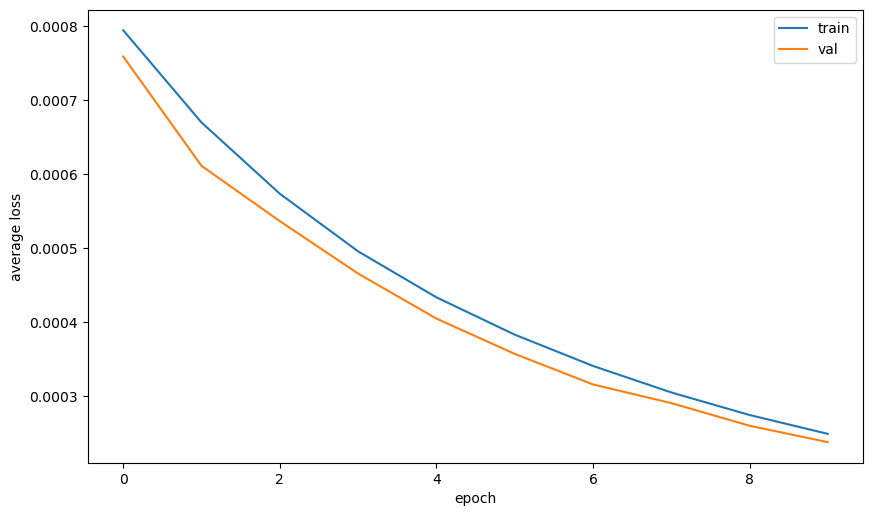

In [8]:
# plot losses for train and val
ax1 = list(range(len(train_loss)))
fig = plt.figure(figsize=(10,6), dpi=100)
plot_train = plt.plot(ax1, train_loss)
plot_val = plt.plot(list(range(len(val_loss))), val_loss)
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.legend(["train", "val"])
plt.show()

In [9]:
  # save model weights
model_filename = "/storage/remote/atcremers40/motion_seg/saved_models/supervised_unet.pt"
torch.save(model, model_filename)

FileNotFoundError: [Errno 2] No such file or directory: '/storage/remote/atcremers40/motion_seg/saved_models/supervised_unet.pt'